In [1]:
import tensorflow as tf
import numpy as np
import time

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./ssd7_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

#Inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

#0=cls, 1=reg, 2=base_layers
tflite_results = interpreter.get_tensor(output_details[0]['index'])


In [6]:
from imageio import imread
from tensorflow.keras.preprocessing import image

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_height=300
img_width=480

# We'll only load one image in this example.
img_path = 'examples/person3.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [8]:
#Inference
interpreter.set_tensor(input_details[0]['index'], input_images)
interpreter.invoke()

#0=cls, 1=reg, 2=base_layers
y_pred = interpreter.get_tensor(output_details[0]['index'])

In [19]:
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.3,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[  1.  ,   0.64,  92.9 ,  75.3 , 150.74, 236.17],
       [  1.  ,   0.37, 175.64,  64.73, 234.72, 206.17],
       [  1.  ,   0.36, 241.48,  63.72, 301.88, 192.61],
       [  1.  ,   0.36, 121.88,  63.53, 216.38, 250.91],
       [  1.  ,   0.3 , 100.64,  73.54, 161.43, 155.14]])]


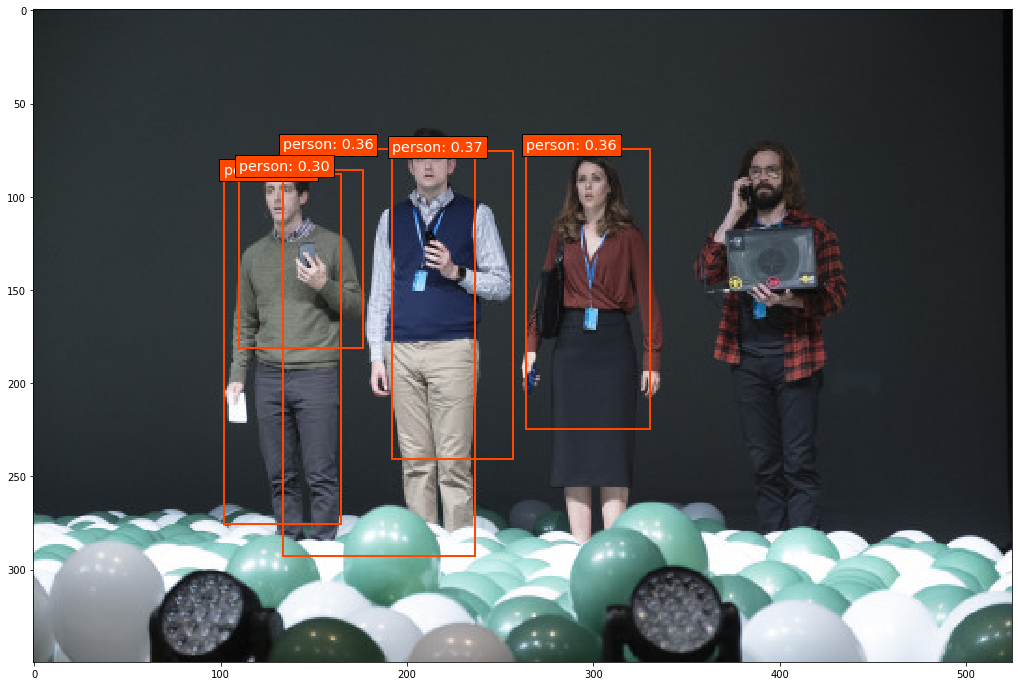

In [20]:
from matplotlib import pyplot as plt

# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'person',]

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})